<a href="https://colab.research.google.com/github/jegraham/1-GNN-Clustering/blob/main/GCN_Simplified_Graham%2C_Jessica_GAE_Clustering_Phase_1_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple K-Means GNN Implementation (Step 1)

This is the initial GNN implementation as referenced in WIDECOMM 2023 Paper Submission. Our implementation uses encoders and decoders with GAT, GCN, and GraphSAGE Layers. Parameters can be modified under the 'Testing Parameters' Section and will be implemented throughout the code.

## Import

### Import Libraries

In [1]:
import os
import os.path as osp
import shutil
import pandas as pd
import random
import datetime

# libraries for the files in google drive
# from pydrive.auth import GoogleAuth
# from google.colab import drive
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [2]:
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn

from collections import Counter
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from scipy import stats
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, FeatureAgglomeration, SpectralClustering, MiniBatchKMeans, Birch, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, pairwise_distances, davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE, GINConv, GATConv
from torch_geometric.utils import train_test_split_edges, to_networkx, from_networkx, to_dense_adj
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit, RemoveDuplicatedEdges
import torch.nn.functional as F


2.5.1+cu124
Using cuda.
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Using pip 24.3.1 from /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/pip (python 3.12)
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this beha

In [3]:
!nvidia-smi

Tue Dec  3 11:03:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| 20%   34C    P8              9W /  250W |      71MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [4]:
# # from google.colab import files

# file_name = 'May 4th Dataset Car and Tower  - Sheet1.csv'
# print(file_name)
# df = pd.read_csv(file_name)
# df = df.reset_index(drop=True)

# print(df.head())

## Testing Parameters

In [5]:
# Define the root directory where the dataset will be stored
root = './'
version = 'v1'
run_id = 'GAT_1000_k_50_dist_150_250_500_transform'

# File Path
folder_path = f'./results/{run_id}_{version}/'
os.makedirs(folder_path, exist_ok=True)


# Define the Number of Clusters
num_clusters = 50
K = num_clusters
clusters = []

num_Infrastructure = 10 #The number of RSU and Towers in the Dataset (always at the start of the dataset)
max_dist_tower = 500 #V2I
max_dist_rsu = 250 #V2R
max_dist = 150 #V2V

# Channel Parameters & GAE MODEL
in_channels = 3
hidden_channels = 5
out_channels = 2

# Transform Parameters
transform_set = True

# Optimizer Parameters (learning rate)
learn_rate = 0.001

# Epochs or the number of generation/iterations of the training dataset
# epoch and n_init refers to the number of times the clustering algorithm will run different initializations
epochs = 4000
n = 1000

# Run GNN

## InMemory Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [6]:
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name
        super().__init__(root, transform, pre_transform)
        self.data = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        from_path = os.path.join(self.root, self.filename)
        to_path = dest = os.path.join(self.raw_dir, self.filename)
        df = pd.read_csv(from_path)
        df.reset_index(drop=True)
        df.to_csv(to_path,index=False)

    def read_file(self):
        path = osp.join(self.raw_dir, self.filename)
        df = pd.read_csv(path)
        df = df.reset_index(drop=True)

        df['Type'] = 0
        df['Type'] = np.where((df['Car ID'].str.contains('RSU')), 2, df['Type'])
        df['Type'] = np.where((df['Car ID'].str.contains('Tower')), 1, df['Type'])
        df = df.drop(columns=['Car ID'])
        return df

    def process(self):
        df = self.read_file()
        df = df.reset_index(drop=True)

        edge_source = []
        edge_target = []


        # Loop row by row to add the edges to the graph
        for i in range(0, len(df)):
            # Inner loop to iterate through all other vehicles
            for j in range(i+1, len(df)):
                  if i != j:
                    dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

                    if (df.iloc[i]['Type'] == 2) or (df.iloc[j]['Type'] == 2):  # RSU
                      # Distance between anything and the Car/Tower/RSU in question
                      # tower to car, tower to tower
                      if 0 < dist <= max_dist_rsu:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)
                    if (df.iloc[i]['Type'] == 1) or (df.iloc[j]['Type'] == 1):
                       if 0 < dist <= max_dist_tower:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)
                    else :
                      if 0 < dist <= max_dist:
                          edge_source.append(i)#No direction
                          edge_target.append(j)
                          edge_source.append(j)#No direction
                          edge_target.append(i)

        data = Data(
            x=torch.tensor(df.values, dtype=torch.float),
            edge_index=torch.tensor([edge_source, edge_target], dtype=torch.long)
        )
        torch.save(data, self.processed_paths[0])

## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=2, bias=True)
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------
Test Error: 
 Avg loss: 4852441600.000000 

Done!
Epoch 2
-------------------------------
Test Error: 
 Avg loss: 4852376064.000000 

Done!
Epoch 3
-------------------------------
Test Error: 
 Avg loss: 4852249088.000000 

Done!
Epoch 4
-------------------------------
Test Error: 
 Avg loss: 4851994624.000000 

Done!
Epoch 5
-------------------------------
Test Error: 
 Avg loss: 4851480064.000000 

Done!
Epoch 6
-------------------------------
Test Error: 
 Avg loss: 4850457600.000000 

Done!
Epoch 7
-------------------------------
Test E

ic| largest_indices: [np.int64(8),
                      np.int64(11),
                      np.int64(11),
                      np.int64(9),
                      np.int64(10),
                      np.int64(7)]
ic| second_largest_indices: [np.int64(10), np.int64(0), np.int64(4), np.int64(2), np.int64(6), np.int64(4)]
ic| largest_indices: [np.int64(3),
                      np.int64(4),
                      np.int64(9),
                      np

['linear_relu_stack.0.weight', 'linear_relu_stack.0.bias', 'linear_relu_stack.1.weight', 'linear_relu_stack.1.bias', 'linear_relu_stack.2.weight', 'linear_relu_stack.2.bias', 'linear_relu_stack.3.weight', 'linear_relu_stack.3.bias', 'linear_relu_stack.4.weight', 'linear_relu_stack.4.bias']
[array([[ 0.12397338,  0.28352028,  0.2823468 ,  0.1587707 ,  0.12804443,
         0.34351417],
       [-0.3106931 ,  0.19401161, -0.1295335 ,  0.1109069 , -0.21101639,
        -0.197841  ],
       [ 0.09395808,  0.09259202,  0.19456883,  0.33778557, -0.25802466,
         0.13601127],
       [ 0.07458566, -0.09821485, -0.19251515, -0.38709235,  0.076116  ,
         0.34572023],
       [-0.4041605 ,  0.21832088,  0.35207164, -0.19437571,  0.06897269,
         0.4527981 ],
       [ 0.11946245, -0.19736955, -0.36558163,  0.09538267,  0.16110578,
         0.05257207],
       [-0.19496632,  0.18518831,  0.22466806, -0.04078969,  0.22065741,
         0.2981064 ],
       [-0.09225123,  0.18763751,  0.138734

.int64(1),
                      np.int64(6),
                      np.int64(9),
                      np.int64(1),
                      np.int64(6),
                      np.int64(5),
                      np.int64(9),
                      np.int64(2),
                      np.int64(1)]
ic| second_largest_indices: [np.int64(4),
                             np.int64(1),
                             np.int64(7),
                             np.int64(4),
                             np.int64(1),
                             np.int64(7),
                             np.int64(0),
                             np.int64(0),
                             np.int64(7),
                             np.int64(7),
                             np.int64(4),
                             np.int64(4)]
ic| tmp: 1
ic| ex_dst: [np.int64(8), np.int64(10)]
ic| largest_indices: [np.int64(2),
                      np.int64(1),
                      np.int64(0),
                      np.int64(1),
              

各列で最大値のインデックス: [np.int64(3), np.int64(4), np.int64(9), np.int64(1), np.int64(6), np.int64(9), np.int64(1), np.int64(6), np.int64(5), np.int64(9), np.int64(2), np.int64(1)]
各列で2番目に大きい値のインデックス: [np.int64(4), np.int64(1), np.int64(7), np.int64(4), np.int64(1), np.int64(7), np.int64(0), np.int64(0), np.int64(7), np.int64(7), np.int64(4), np.int64(4)]
8
10
src: [0, 0, np.int64(14), np.int64(14), np.int64(16), np.int64(16)]
dst: [np.int64(14), np.int64(16), np.int64(23), np.int64(25), np.int64(20), np.int64(22)]
------------------------------------------------
各列で最大値のインデックス: [np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(3)]
各列で2番目に大きい値のインデックス: [np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(2), np.int64(4), np.int64(4), np.int64(4)]
5
7
2
4
src: [0, 0, np.int64(14), np.int64(14), np.int64(16), np.int64(16), np.int64(23), np.int64(23), np.int64(25), np.int64(25), np.int64(2


ic| result: []
ic| src.shape: (30,)
ic| edge_attr: array([0.30380777, 0.21537125, 1.6967269 , 1.8555771 , 2.0060174 ,
                      1.9884784 , 2.1681366 , 2.0436745 , 2.1681366 , 2.0436745 ,
                      1.9375198 , 2.104879  , 1.9817157 , 2.104879  , 2.2602022 ,
                      1.5831801 , 2.2602022 , 1.5831801 , 2.2602022 , 1.5831801 ,
                      2.2602022 , 1.5831801 , 2.2602022 , 1.5831801 , 2.4382558 ,
                      2.0533082 , 2.2602022 , 1.5831801 , 2.4382558 , 2.0533082 ],
                     dtype=float32)
/home/csl-stu/work/2121057/research/17/laten_space/rosenbrock_nn_weigth.py:496: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index=torch.tensor([src,dst],dtype=torch.long)
ic| dataset: Data(x=[34, 34], edge_index=[

3
4
3
4
0
2
1
2
src: [0, 0, np.int64(14), np.int64(14), np.int64(16), np.int64(16), np.int64(23), np.int64(23), np.int64(25), np.int64(25), np.int64(20), np.int64(20), np.int64(22), np.int64(22), np.int64(31), np.int64(31), np.int64(32), np.int64(32), np.int64(31), np.int64(31), np.int64(32), np.int64(32), np.int64(28), np.int64(28), np.int64(30), np.int64(30), np.int64(29), np.int64(29), np.int64(30), np.int64(30)]
dst: [np.int64(14), np.int64(16), np.int64(23), np.int64(25), np.int64(20), np.int64(22), np.int64(31), np.int64(32), np.int64(31), np.int64(32), np.int64(28), np.int64(30), np.int64(29), np.int64(30), np.int64(34), np.int64(33), np.int64(34), np.int64(33), np.int64(34), np.int64(33), np.int64(34), np.int64(33), np.int64(34), np.int64(33), np.int64(33), np.int64(34), np.int64(34), np.int64(33), np.int64(33), np.int64(34)]
------------------------------------------------
各列の平均: [0.01618438 0.03889414 0.05683409 0.01211178 0.05406332 0.1503415 ]
Number of graphs: 5
dataset Da

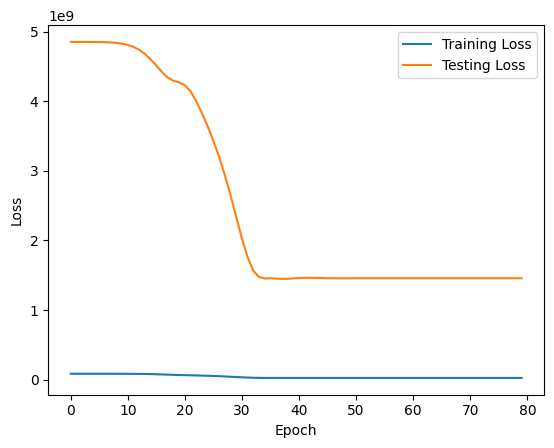

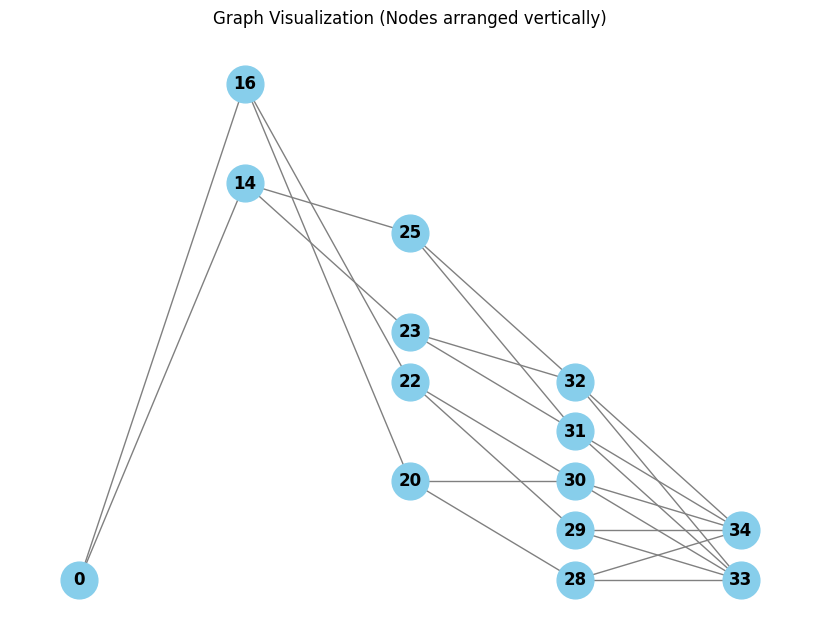

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from rosenbrock_nn_weigth import dim_num_dataset
dataset = dim_num_dataset(dim_values=0)
dataset_ =dataset
# if transform_set:
#   dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
# else:
#   dataset = MyDataset(root,file_name)


data = dataset
data_ = dataset_

# transform = RemoveDuplicatedEdges()
# data = transform(data)
# data_ = transform(data_)

transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.15,
    is_undirected=True,
    split_labels=True,
    add_negative_train_samples=True)
import torch

# data.edge_indexがnumpy.ndarrayの場合、torch.Tensorに変換
if isinstance(data.edge_index, np.ndarray):
    data.edge_index = torch.tensor(data.edge_index, dtype=torch.long)
if isinstance(data.x, np.ndarray):
    data.x = torch.tensor(data.x, dtype=torch.float)
    
if isinstance(data.edge_attr, np.ndarray):
    data.edge_attr = torch.tensor(data.edge_attr, dtype=torch.float)

train_data, val_data, test_data = transform(data)

# Display Graphs
print(f'Number of graphs: {len(dataset)}')
print('dataset',dataset) ## dataset is vector with size 1 because we have one graph

print(f'Number of features: {dataset.num_features}')
print('------------')

# Print information for initialization
print('data', data)
print('train data',train_data)
print('valid data', val_data)
print('test data', test_data)
print('------------')

print(data.is_directed())

## Build Graph for Visualization

### Visualize Entire Data


Data(x=[34, 34], edge_index=[2, 30], edge_attr=[30], y=[34], num_classes=4)


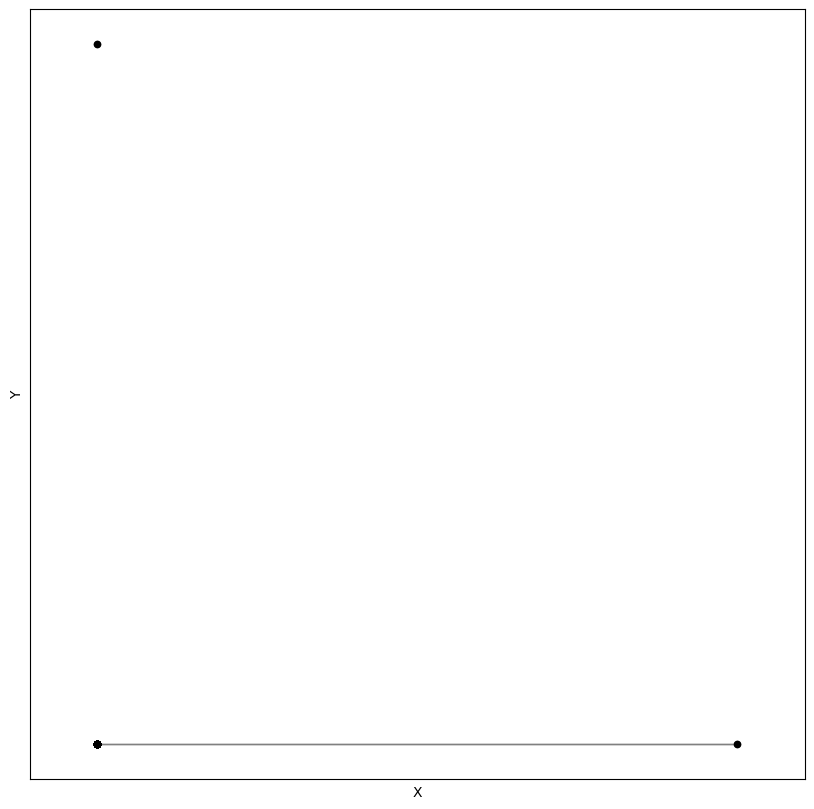

In [9]:
print(data_)

G = to_networkx(data_)
G = G.to_undirected()

X = data_.x[:,[0,1]].cpu().detach().numpy()
# pos = dict(zip(range(X[:, 0].size), X))
# posに不足しているノードの位置を補完
pos = {i: X[i] if i < X.shape[0] else (0, 0) for i in range(G.number_of_nodes())}

# Draw the Graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:,0], X[:,1], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-initial-graph', format='eps', dpi=300)
plt.show()

### Define the Encoder
Change the Encoder based on the type testing against

In [10]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels):
      super(GCNEncoder, self).__init__()

      # GCN
      self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
      self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning

      # SAGE
      # self.conv1 = SAGEConv(in_channels, hidden_channels, cached=True) # cached only for transductive learning
      # self.conv2 = SAGEConv(hidden_channels, out_channels, cached=True) # cached only for transductive learning

      # GAT
      # self.in_head = 8
      # self.out_head = 1
      # self.conv1 = GATConv(in_channels, hidden_channels, heads=self.in_head, dropout=0.6)
      # self.conv2 = GATConv(hidden_channels*self.in_head, out_channels, concat=False)#, heads=self.out_head, dropout=0.6)


    def forward(self, x, edge_index):
      x = self.conv1(x, edge_index).relu()
      x = F.dropout(x, p=0.6, training=self.training)
      x = self.conv2(x, edge_index)
      return x



### Define the Autoencoder



In [11]:
# Initialize the Model
model = GAE(GCNEncoder(in_channels, hidden_channels, out_channels))

model = model.to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)
data_ = data_.to(device)

# Inizialize the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)
print(model)

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(3, 5)
    (conv2): GCNConv(5, 2)
  )
  (decoder): InnerProductDecoder()
)


In [12]:
def train(dt):
    model.train()
    optimizer.zero_grad()
    z = model.encode(dt.x, dt.pos_edge_label_index)
    loss = model.recon_loss(z, dt.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(dt):
    model.eval()
    with torch.no_grad():
      z = model.encode(dt.x, dt.pos_edge_label_index)
    return model.test(z, dt.pos_edge_label_index, dt.neg_edge_label_index)


In [15]:
auc_values=[]
ap_values =[]

best_auc = 0.0  # Track the best AUC value
consecutive_epochs = 0  # Track the number of consecutive epochs with AUC not increasing
auc = 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

for epoch in range(1, epochs + 1):
    loss = train(train_data)


    if (epoch % 100 == 0):
        # Area under Curve (AUC) and Average Precision (AP)
        auc, ap = test(test_data)
        print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
        auc_values.append(auc)
        ap_values.append(ap)

    # Check for early stopping
    if (auc >= (best_auc - 0.01 * best_auc)):  # Check if auc is less than or equal to 1% decrease
      if (auc >= 0.8):
          best_auc = auc
          consecutive_epochs = 0
    else:
       consecutive_epochs += 1

    if consecutive_epochs >= 10:
       print('Early stopping: AUC has not increased by more than 1% for 10 epochs.')
       break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Z (Latent Representation)


#### Clustering with only (Node) Features

In [ ]:
#------------------------------------------------------------Baseline Approach Clustering
node_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
node_eval_data = data_
node_X = node_eval_data.x[:,[0,1]].cpu().detach().numpy()

node_df = pd.DataFrame(node_X, columns = ['X','Y'])
node_kmeans.fit(node_df[['X', 'Y']])

# Adding cluster labels to the DataFrame
df_with_cluster = df.copy(deep=True)
df_with_cluster['cluster'] = node_kmeans.labels_
node_cluster_centers = node_kmeans.cluster_centers_

node_G = to_networkx(node_eval_data)
node_G = G.to_undirected()
node_labels = node_kmeans.labels_

node_pos = dict(zip(range(node_X[:, 0].size), node_X))

## Draw the Graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_with_cluster['X'], df_with_cluster['Y'], s=20, color='grey')
nx.draw_networkx_nodes(node_G, node_pos, cmap=plt.get_cmap('tab20'), node_color = node_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(node_G, node_pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-node-features-baseline', format='eps', dpi=300)
plt.show()

### KMeans Clustering with Graph and Features

In [ ]:
#----------------------------------GNN Approach
model.eval()
with torch.no_grad():
  z = model.encode(data_.x, data_.edge_index)

# Perform KMeans clustering on the latent space (z)
z = z.cpu().detach().numpy()
gnn_kmeans = KMeans(n_clusters=num_clusters, n_init=n).fit(z)
gnn_eval_data = data_
gnn_X = gnn_eval_data.x[:,[0,1]].cpu().detach().numpy()
gnn_df = pd.DataFrame(gnn_X, columns = ['X','Y'])

# Adding cluster labels to the DataFrame
gnn_df_with_cluster = gnn_df.copy(deep=True)
gnn_df_with_cluster['cluster'] = gnn_kmeans.labels_

gnn_G = to_networkx(gnn_eval_data)
gnn_G = gnn_G.to_undirected()
gnn_labels = gnn_kmeans.labels_
gnn_cluster_centers = gnn_kmeans.cluster_centers_


gnn_pos = dict(zip(range(gnn_X[:, 0].size), gnn_X))

# Draw the Graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(gnn_df_with_cluster['X'], gnn_df_with_cluster['Y'], s=20, color='grey')
nx.draw_networkx_nodes(gnn_G, gnn_pos, cmap=plt.get_cmap('tab20'), node_color = gnn_labels, node_size=20, ax=ax)
nx.draw_networkx_edges(gnn_G, gnn_pos, edge_color='grey', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.savefig(f'{folder_path}{run_id}_{version}-kmeans-cluster-node-features-gnn', format='eps', dpi=300)
plt.show()

# Performance Analysis

### Save to CSV

In [ ]:
import csv

def save_array_to_csv(r_id, ftype, v, array_data, title_count, title_type, row_title, row_number):
    file_exists = os.path.exists(f"{r_id}_{ftype}_{title_type}_{v}.csv")
    file_path = f"{folder_path}{r_id}_{ftype}_{title_type}_{v}.csv"

    try:
        mode = 'a' if os.path.exists(file_path) else 'w'

        # Use 'a' mode (append), w mode to write to open the file
        with open(file_path, mode=mode, newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            # If the file doesn't exist, write the titles
            if mode == 'w':
                titles = [f"{row_title}"]

                for i in range(title_count):
                    titles.append(f"{i+1}")

                csv_writer.writerow(titles)

            if isinstance(array_data, list) and all(isinstance(row, list) for row in array_data):
                # Write the data rows
                print("if")
                for row in enumerate(len(array_data[0]), start=1):
                    csv_writer.writerow(array_data[row])
            else:
                print("else")
                row_name = [f"{row_title} {row_number}"]  + array_data
                csv_writer.writerow(row_name)

        print(f"Data successfully saved to {file_path}.")
    except Exception as e:
          print(f"Error occurred while saving data to {file_path}: {e}")

### Graph Epoch AUC and AP - Works



In [ ]:
# Good values for AUC and AP
good_auc = 0.8
good_ap = 0.5

# Plot AUC & AP values
x_values = range(1, len(auc_values) + 1)
plt.plot(x_values, auc_values, label='AUC')
plt.plot(x_values, ap_values, label='AP')
plt.axhline(y=good_auc, color='blue', linestyle='dashed', label=f'Good AUC: {good_auc}')
plt.axhline(y=good_ap, color='orange', linestyle='dashed', label=f'Good AP: {good_ap}')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('AUC and AP Progression')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-auc-ap.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-auc-ap.png', format='png', dpi=300)
plt.show()


###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'auc', version, auc_values, epoch, 'epoch', 'cluster', num_clusters)
save_array_to_csv(run_id, 'ap', version, ap_values, epoch, 'epoch', 'cluster', num_clusters)


### Clustering Visualizations

In [ ]:
print("------------KMeans Baseline Approach---------------")
node_cluster_head_indices = []
node_distances_to_centers = node_kmeans.transform(node_X)
for i in range(num_clusters):
    node_cluster_data_indices = np.where(node_labels == i)[0]
    node_distances_to_center = node_distances_to_centers[node_cluster_data_indices, i]
    node_cluster_head_index = node_cluster_data_indices[np.argmin(node_distances_to_center)]
    node_cluster_head_indices.append(node_cluster_head_index)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(node_G, node_pos, alpha=0.1, ax=ax)
node_scatter = ax.scatter(X[:, 0], X[:, 1], s=20, color='grey', label='Nodes')
nx.draw_networkx_nodes(node_G, node_pos, cmap=plt.get_cmap('tab20'), node_color=node_labels, node_size=20, ax=ax)

node_cluster_x, node_cluster_y = zip(*node_cluster_centers)
cluster_scatter = ax.scatter(node_cluster_x, node_cluster_y, marker='x', s=125, c='black', label='Cluster Centers')

node_cluster_head_x = [X[i][0] for i in node_cluster_head_indices]
node_cluster_head_y = [X[i][1] for i in node_cluster_head_indices]
cluster_head_scatter = ax.scatter(node_cluster_head_x, node_cluster_head_y, marker='D', s=200, c='black', edgecolors='white', linewidth=1, label='Cluster Heads')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(handles=[node_scatter, cluster_scatter, cluster_head_scatter])
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-baseline.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-baseline.png', format='png', dpi=300)
plt.show()

In [ ]:
print("--------------MANUAL CLUSTER HEAD CALCULATION FOR GNN--------------")
cluster_centers = gnn_df_with_cluster.groupby('cluster')[['X', 'Y']].mean()

gnn_closest_node_indices = []
for cluster_id, (center_x, center_y) in enumerate(zip(cluster_centers['X'], cluster_centers['Y'])):
    gnn_distances = np.linalg.norm(gnn_df_with_cluster[['X', 'Y']].values - np.array([center_x, center_y]), axis=1)
    gnn_closest_node_index = np.argmin(gnn_distances)
    gnn_closest_node_indices.append(gnn_closest_node_index)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(gnn_G, gnn_pos, alpha=0.1, ax=ax)
gnn_scatter = ax.scatter(gnn_df_with_cluster['X'], gnn_df_with_cluster['Y'], s=20, color='grey', label='Nodes')
nx.draw_networkx_nodes(gnn_G, gnn_pos, cmap=plt.get_cmap('tab20'), node_color=gnn_labels, node_size=20, ax=ax)

cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='black', edgecolors='white', linewidth=1, label='Cluster Centers')
cluster_head_scatter = ax.scatter(gnn_df_with_cluster.loc[gnn_closest_node_indices, 'X'], gnn_df_with_cluster.loc[gnn_closest_node_indices, 'Y'], marker='D', s=200, c='black', edgecolors='white', linewidth=1, label='Cluster Heads')

ax.set_xlabel('X')
ax.set_ylabel('Y')

handles, labels = ax.get_legend_handles_labels()
handles.append(cluster_center_scatter)
handles.append(cluster_head_scatter)
ax.legend(handles=handles, labels=labels)

plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-gnn.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-gnn.png', format='png', dpi=300)
plt.show()


In [ ]:
print("---------------Combined--------------")
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(gnn_G, gnn_pos, alpha=0.1, ax=ax)
node_scatter = ax.scatter(gnn_X[:, 0], gnn_X[:, 1], s=20, color='grey')
gnn_cluster_center_scatter = ax.scatter(cluster_centers['X'], cluster_centers['Y'], marker='x', s=125, c='green', edgecolors='white', linewidth=1, label='GNN Cluster Centers')
gnn_cluster_head_scatter = ax.scatter(gnn_df_with_cluster.loc[gnn_closest_node_indices, 'X'], gnn_df_with_cluster.loc[gnn_closest_node_indices, 'Y'], marker='D', s=200, c='green', edgecolors='white', linewidth=1, label='GNN Cluster Heads')
node_cluster_head_scatter = ax.scatter(node_cluster_head_x, node_cluster_head_y, marker='D', s=100, c='red', edgecolors='white', linewidth=1, label='KMeans Cluster Heads')
node_cluster_scatter = ax.scatter(node_cluster_x, node_cluster_y, marker='x', s=125, c='red', label='KMeans Cluster Centers')

node_scatter.set_label('Nodes')
ax.set_xlabel('X')
ax.set_ylabel('Y')
handles = [gnn_cluster_head_scatter, node_cluster_head_scatter, node_scatter]
labels = [h.get_label() for h in handles]
ax.legend(handles=handles, labels=labels)
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-combined-V1.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-cluster-centers-node-features-combined-V1.png', format='png', dpi=300)
plt.show()

### Generate Multiple Clusters

In [ ]:
rsu_list = node_df[:num_Infrastructure].to_numpy()

In [ ]:
num_clusters_range = range(2, K + 1)

print("-------------------KMeans Baseline Approach---------------------")
node_sse_values = []
node_min_cluster_sizes = []
node_max_cluster_sizes = []
node_median_cluster_sizes = []
node_avg_cluster_distances = []
node_centroid_avg_distances = []
node_avg_cluster_densities = []
node_silhouette_scores = []
node_davies_bouldin_scores = []
node_ari_values = []
node_avg_intra_distances = []
node_avg_inter_distances = []
node_nmi_values = []
node_calinski_harabasz_scores = []
node_inertia_values = []


for num_clusters in num_clusters_range:
    print("Cluster (Baseline): ", num_clusters)
    node_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
    node_eval_data = data_
    node_X = node_eval_data.x[:,[0,1]].cpu().detach().numpy()

    node_df = pd.DataFrame(node_X, columns = ['X','Y'])
    node_kmeans.fit(node_X)

    # Adding cluster labels to the DataFrame
    df_with_cluster = df.copy(deep=True)
    node_labels = node_kmeans.labels_
    df_with_cluster['cluster'] = node_labels
    node_cluster_centers = node_kmeans.cluster_centers_

    node_G = to_networkx(node_eval_data)
    node_G = G.to_undirected()

    node_pos = dict(zip(range(node_X[:, 0].size), node_X))
    node_cluster_sizes = dict(Counter(node_labels))

    # Calculate SSE for the current cluster size
    node_sse = node_kmeans.inertia_
    node_sse_values.append(node_sse)

    # Calculate MSE from SSE values
    node_mse_values = np.array(node_sse_values) / len(node_X)

    node_calinski_harabasz_scores.append(calinski_harabasz_score(node_X, node_labels))
    node_inertia_values.append(node_kmeans.inertia_)
    # node_ari_values.append(adjusted_rand_score(true_labels, node_labels))  # Replace true_labels with your ground truth labels


    node_intra_distances = np.zeros(num_clusters)

    for cluster in range(num_clusters):
        cluster_mask = node_labels == cluster
        cluster_distances = np.linalg.norm(node_X[cluster_mask] - node_kmeans.cluster_centers_[cluster], axis=1)
        node_intra_distances[cluster] = np.mean(cluster_distances)
    node_avg_intra_distances.append(np.mean(node_intra_distances))

    # Calculate inter-cluster distances for KMeans
    node_inter_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        other_clusters_centers = np.delete(node_kmeans.cluster_centers_, cluster, axis=0)
        cluster_distances = np.linalg.norm(other_clusters_centers - node_kmeans.cluster_centers_[cluster], axis=1)
        node_inter_distances[cluster] = np.mean(cluster_distances)
    node_avg_inter_distances.append(np.mean(node_inter_distances))

    # Calculate Silhouette Score for the current cluster size
    node_silhouette_score = silhouette_score(node_X, node_labels)
    node_silhouette_scores.append(node_silhouette_score)

    # Calculate Davies-Bouldin Index for the current cluster size
    node_davies_bouldin_score = davies_bouldin_score(node_X, node_labels)
    node_davies_bouldin_scores.append(node_davies_bouldin_score)

    # Calculate the minimum, maximum, and median cluster sizes
    node_min_cluster_size = min(node_cluster_sizes.values())
    node_max_cluster_size = max(node_cluster_sizes.values())
    node_median_cluster_size = np.median(list(node_cluster_sizes.values()))

    # Save the cluster size statistics
    node_min_cluster_sizes.append(node_min_cluster_size)
    node_max_cluster_sizes.append(node_max_cluster_size)
    node_median_cluster_sizes.append(node_median_cluster_size)

    node_cluster_node_avg_distances = []
    node_distances_to_centers = node_kmeans.transform(node_X)
    for cluster in range(num_clusters):
        node_cluster_mask = node_labels == cluster
        node_cluster_distances = node_distances_to_centers[node_cluster_mask]
        node_cluster_node_avg_distance = np.mean(node_cluster_distances)
        node_cluster_node_avg_distances.append(node_cluster_node_avg_distance)

    # Calculate the average cluster distance for the current cluster size
    node_avg_cluster_distance = np.mean(node_cluster_node_avg_distances)
    node_avg_cluster_distances.append(node_avg_cluster_distance)

    # Calculate the average cluster density for the current cluster size
    node_avg_cluster_density = len(node_df)/ sum(node_cluster_node_avg_distances)
    node_avg_cluster_densities.append(node_avg_cluster_density)

    min_list = []
    for i in range(num_clusters):
        min_dist = float('inf')
        total = []
        for j in range(len(rsu_list)):
            dist = math.sqrt((rsu_list[j][0] - node_cluster_centers[i][0])**2 + (rsu_list[j][1] - node_cluster_centers[i][1])**2)
            if dist < min_dist:
              min_dist = dist
        min_list.append(min_dist)

    node_centroid_min_avg_distance = np.mean(min_list)
    node_centroid_avg_distances.append(node_centroid_min_avg_distance)

    # Calculate distances from data points to their respective cluster centers------------------------
    node_distances_to_centers = np.zeros(node_X.shape[0])
    for i in range(node_X.shape[0]):
        node_cluster_idx = node_labels[i]
        node_distance = np.linalg.norm(node_X[i] - node_cluster_centers[node_cluster_idx])
        node_distances_to_centers[i] = node_distance

    # Sort the distances in ascending order
    node_sorted_distances = np.sort(node_distances_to_centers)

    # Compute the cumulative probabilities for each distance
    cumulative_probabilities = np.arange(1, len(node_sorted_distances) + 1) / len(node_sorted_distances)

    # Fit a continuous distribution to the distances and obtain the CDF values for the fitted distribution
    fitted_distribution = stats.rv_histogram(np.histogram(node_sorted_distances, bins=20))
    cdf_fitted = fitted_distribution.cdf(node_sorted_distances)

    # Plot the CDF curve for the current cluster size as a smooth line
    ax.plot(node_sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}') #----------------------------

In [ ]:
print("---------------------GNN---------------------")
gnn_sse_values = []
gnn_min_cluster_sizes = []
gnn_max_cluster_sizes = []
gnn_median_cluster_sizes = []
gnn_avg_cluster_distances = []
gnn_centroid_avg_distances = []
gnn_avg_cluster_densities = []
gnn_silhouette_scores = []
gnn_davies_bouldin_scores = []
gnn_avg_intra_distances = []
gnn_ari_values = []
gnn_avg_inter_distances = []
gnn_ari_values = []
gnn_calinski_harabasz_scores = []
gnn_inertia_values = []
gnn_intra_distances = np.zeros(num_clusters)
gnn_inter_distances = np.zeros(num_clusters)

for num_clusters in num_clusters_range:
    print("Cluster (GNN): ", num_clusters)
    gnn_kmeans = KMeans(n_clusters=num_clusters, n_init=n)
    gnn_eval_data = data_
    gnn_X = gnn_eval_data.x[:,[0,1]].cpu().detach().numpy()

    gnn_df = pd.DataFrame(gnn_X, columns = ['X','Y'])
    gnn_kmeans.fit(gnn_X)

    # Adding cluster labels to the DataFrame
    df_with_cluster = df.copy(deep=True)
    gnn_labels = gnn_kmeans.labels_
    df_with_cluster['cluster'] = gnn_labels


    # ----------------------------------------------------------MANUAL CLUSTER HEAD AND CENTER
    # Calculate cluster centers
    gnn_cluster_centers = gnn_df_with_cluster.groupby('cluster')[['X', 'Y']].mean()
    gnn_closest_node_indices = []
    for cluster_id, (center_x, center_y) in enumerate(zip(gnn_cluster_centers['X'], gnn_cluster_centers['Y'])):
        gnn_distances = np.linalg.norm(gnn_df_with_cluster[['X', 'Y']].values - np.array([center_x, center_y]), axis=1)
        gnn_closest_node_index = np.argmin(gnn_distances)
        gnn_closest_node_indices.append(gnn_closest_node_index)

    gnn_G = to_networkx(gnn_eval_data)
    gnn_G = G.to_undirected()

    gnn_pos = dict(zip(range(gnn_X[:, 0].size), gnn_X))

    gnn_cluster_sizes = dict(Counter(gnn_labels))

    # Calculate SSE for the current cluster size
    gnn_sse = gnn_kmeans.inertia_
    gnn_sse_values.append(gnn_sse)

    # Calculate MSE from SSE values
    gnn_mse_values = np.array(gnn_sse_values) / len(gnn_X)

    # Calculate Silhouette Score for the current cluster size
    gnn_silhouette_score = silhouette_score(gnn_X, gnn_labels)
    gnn_silhouette_scores.append(gnn_silhouette_score)

    # Calculate Davies-Bouldin Index for the current cluster size
    gnn_davies_bouldin_score = davies_bouldin_score(gnn_X, gnn_labels)
    gnn_davies_bouldin_scores.append(gnn_davies_bouldin_score)

    gnn_calinski_harabasz_scores.append(calinski_harabasz_score(gnn_X, gnn_labels))
    gnn_inertia_values.append(gnn_kmeans.inertia_)

    # Calculate intra-cluster distances for GNN
    gnn_intra_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        cluster_mask = gnn_labels == cluster
        cluster_distances = np.linalg.norm(gnn_X[cluster_mask] - gnn_kmeans.cluster_centers_[cluster], axis=1)
        gnn_intra_distances[cluster] = np.mean(cluster_distances)

    # Calculate inter-cluster distances for GNN
    gnn_inter_distances = np.zeros(num_clusters)
    for cluster in range(num_clusters):
        other_clusters_centers = np.delete(gnn_kmeans.cluster_centers_, cluster, axis=0)
        cluster_distances = np.linalg.norm(other_clusters_centers - gnn_kmeans.cluster_centers_[cluster], axis=1)
        gnn_inter_distances[cluster] = np.mean(cluster_distances)

    gnn_avg_inter_distances.append(np.mean(gnn_inter_distances))
    gnn_avg_intra_distances.append(np.mean(gnn_intra_distances))

    # Calculate the minimum, maximum, and median cluster sizes
    gnn_min_cluster_size = min(gnn_cluster_sizes.values())
    gnn_max_cluster_size = max(gnn_cluster_sizes.values())
    gnn_median_cluster_size = np.median(list(gnn_cluster_sizes.values()))

    # Save the cluster size statistics
    gnn_min_cluster_sizes.append(gnn_min_cluster_size)
    gnn_max_cluster_sizes.append(gnn_max_cluster_size)
    gnn_median_cluster_sizes.append(gnn_median_cluster_size)

    gnn_cluster_node_avg_distances = []
    gnn_distances_to_centers = gnn_kmeans.transform(gnn_X)
    for cluster in range(num_clusters):
        gnn_cluster_mask = gnn_kmeans.labels_ == cluster
        gnn_cluster_distances = gnn_distances_to_centers[gnn_cluster_mask]
        gnn_cluster_node_avg_distance = np.mean(gnn_cluster_distances)
        gnn_cluster_node_avg_distances.append(gnn_cluster_node_avg_distance)

    # Calculate the average cluster distance for the current cluster size
    gnn_avg_cluster_distance = np.mean(gnn_cluster_node_avg_distances)
    gnn_avg_cluster_distances.append(gnn_avg_cluster_distance)

    # Calculate the average cluster density for the current cluster size
    gnn_avg_cluster_density = len(gnn_df) / sum(gnn_cluster_node_avg_distances)
    gnn_avg_cluster_densities.append(gnn_avg_cluster_density)

    min_list = []
    for i in range(num_clusters):
      min_dist = float('inf')
      total = []
      for j in range(len(rsu_list)):
          dist = math.sqrt((rsu_list[j][0] - gnn_cluster_centers.iloc[i]['X'])**2 + (rsu_list[j][1] - gnn_cluster_centers.iloc[i]['Y'])**2)
          if dist < min_dist:
              min_dist = dist
      min_list.append(min_dist)

    gnn_centroid_min_avg_distance = np.mean(min_list)
    gnn_centroid_avg_distances.append(gnn_centroid_min_avg_distance)

    # Calculate distances from data points to their respective cluster centers------------------------
    gnn_distances_to_centers = np.zeros(gnn_X.shape[0])
    for i in range(gnn_X.shape[0]):
        gnn_cluster_idx = gnn_labels[i]
        gnn_distance = np.linalg.norm(gnn_X[i] - gnn_cluster_centers.iloc[gnn_cluster_idx])
        gnn_distances_to_centers[i] = gnn_distance

    # Sort the distances in ascending order
    gnn_sorted_distances = np.sort(gnn_distances_to_centers)

    # Compute the cumulative probabilities for each distance
    cumulative_probabilities = np.arange(1, len(gnn_sorted_distances) + 1) / len(gnn_sorted_distances)

    # Fit a continuous distribution to the distances and obtain the CDF values for the fitted distribution
    fitted_distribution = stats.rv_histogram(np.histogram(gnn_sorted_distances, bins=20))
    cdf_fitted = fitted_distribution.cdf(gnn_sorted_distances)

    # Plot the CDF curve for the current cluster size as a smooth line
    ax.plot(gnn_sorted_distances, cdf_fitted, label=f'Cluster Size {num_clusters}') #----------------------------

### Sum of Squares (SSE - Elbow)

In [ ]:
print("---------------KMeans Baseline Approach----------------")
plt.plot(num_clusters_range, node_sse_values, marker='o', linestyle='-', color='red',label='SSE KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-sse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-sse-elbow.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-sse-elbow', version, node_sse_values, num_clusters_range, 'cluster', 'cluster', 's')


In [ ]:
print("---------------GNNS----------------")
plt.plot(num_clusters_range, gnn_sse_values, marker='o', linestyle='-',color='green', label='SSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-sse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-sse-elbow.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-sse-elbow', version, gnn_sse_values, num_clusters, 'cluster', 'cluster', 's')

In [ ]:
print("---------------COMBINED----------------")
plt.plot(num_clusters_range, node_sse_values, marker='o', linestyle='-', color='red', label='SSE KMeans')
plt.plot(num_clusters_range, gnn_sse_values, marker='o', linestyle='-', color ='green', label='SSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE) / Distortion')
plt.title('SSE for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-sse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-sse-elbow.png', format='png', dpi=300)
plt.show()

### Mean Squared Error (MSE)

In [ ]:
print("--------------KMeans Baseline Approach---------------")
plt.plot(num_clusters_range, node_mse_values, marker='o', linestyle='-', color='red',label='MSE KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-mse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-mse-elbow.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-mse-elbow', version, node_mse_values, num_clusters, 'cluster', 'cluster', 's')

In [ ]:
print("-------------GNN--------------")
plt.plot(num_clusters_range, gnn_mse_values, marker='o', linestyle='-', color='green',label='MSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-mse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-mse-elbow.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-mse-elbow', version, gnn_mse_values, num_clusters, 'cluster', 'cluster', 's')

In [ ]:
print("-------------COMBINED--------------")
plt.plot(num_clusters_range, node_mse_values, marker='o', linestyle='-',color='red', label='MSE KMeans')
plt.plot(num_clusters_range, gnn_mse_values, marker='o', linestyle='-', color='green', label='MSE GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-mse-elbow.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-mse-elbow.png', format='png', dpi=300)
plt.show()

### Silhoutte Score

In [ ]:
print("-------------------KMeans Baseline Approach-------------")
plt.plot(num_clusters_range, node_silhouette_scores, marker='o', linestyle='-', color='red', label='Silhouette Score KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-silhouette.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-silhouette.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-silhouette', version, node_silhouette_scores, num_clusters_range, 'cluster', 'score', 'f')

In [ ]:
print("--------------GNN--------------")
plt.plot(num_clusters_range, gnn_silhouette_scores, marker='o', linestyle='-', color='green',label='Silhouette Score GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-silhouette.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-silhouette.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-silhouette', version, gnn_silhouette_scores, num_clusters, 'cluster', 'score', 'f')

In [ ]:
print("--------------COMBINED--------------")
plt.plot(num_clusters_range, node_silhouette_scores, marker='o', linestyle='-', color='red', label='KMeans Silhouette Score KMeans')
plt.plot(num_clusters_range, gnn_silhouette_scores, marker='o', linestyle='-', color='green', label='GNN Silhouette Score GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-silhouette.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-silhouette.png', format='png', dpi=300)
plt.show()

### Davies-Bouldin Index

In [ ]:
print("-------------KMeans Baseline Approach--------------")
plt.plot(num_clusters_range, node_davies_bouldin_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-davies-bouldin.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-non-gnn-davies-bouldin.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-davies-bouldin', version, node_davies_bouldin_scores, num_clusters, 'cluster', 'score', 'f')

In [ ]:
print("-------------GNN--------------")

# Plot the Davies-Bouldin Index scores
plt.plot(num_clusters_range, gnn_davies_bouldin_scores, marker='o', linestyle='-', color='green', label='Davies-Bouldin Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes GNN')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-davies-bouldin.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-davies-bouldin.png', format='png', dpi=300)
plt.show()

###-----------------------------------------------------------------------------------------Call the method and filename here
save_array_to_csv(run_id, 'gnn-davies-bouldin', version, node_davies_bouldin_scores, num_clusters, 'cluster', 'score', 'f')

In [ ]:
print("-------------COMBINED-------------")

# Plot the Davies-Bouldin Index scores
plt.plot(num_clusters_range, node_davies_bouldin_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index KMeans')
plt.plot(num_clusters_range, gnn_davies_bouldin_scores, marker='o', linestyle='-', color='green', label='Davies-Bouldin Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Varying Cluster Sizes GNN and Baseline')
plt.legend()

# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-combined-davies-bouldin.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-davies-bouldin.png', format='png', dpi=300)
plt.show()

### Calinski-Harabasz Index

In [ ]:
print("-------------COMBINED-------------")
plt.plot(num_clusters_range, node_calinski_harabasz_scores, marker='o', linestyle='-', color='red', label='Calinski-Harabasz Index KMeans')
plt.plot(num_clusters_range, gnn_calinski_harabasz_scores, marker='o', linestyle='-', color='green', label='Calinski-Harabasz Index GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-calinski-harabasz.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-calinski-harabasz.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-calinski', version, node_calinski_harabasz_scores, num_clusters_range, 'cluster', 'score', 'f')
save_array_to_csv(run_id, 'gnn-calinski', version, gnn_calinski_harabasz_scores, num_clusters_range, 'cluster', 'score', 'f')

### Inertia

In [ ]:
print("-------------COMBINED-------------")
plt.plot(num_clusters_range, node_inertia_values, marker='o', linestyle='-', color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_inertia_values, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Analysis for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-inertia.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-inertia.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-inertia_values', version, node_inertia_values, num_clusters_range, 'cluster', 'score', 'f')
save_array_to_csv(run_id, 'gnn-inertia_values', version, gnn_inertia_values, num_clusters_range, 'cluster', 'score', 'f')

### Inter and Intra Cluster Distance

In [ ]:
print("-------------COMBINED-------------")
plt.plot(num_clusters_range, node_avg_intra_distances, marker='o', linestyle='-', color='red', label='KMeans Intra')
plt.plot(num_clusters_range, node_avg_inter_distances, marker='o', linestyle='-', color='blue', label='KMeans Inter')
plt.plot(num_clusters_range, gnn_avg_intra_distances, marker='o', linestyle='-', color='green', label='GNN Intra')
plt.plot(num_clusters_range, gnn_avg_inter_distances, marker='o', linestyle='-', color='purple', label='GNN Inter')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Inter and Intra-Cluster Distances for Varying Cluster Sizes GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-distance-analysis.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-distance-analysis.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'node_avg_intra_distances', version, node_avg_intra_distances, num_clusters_range, 'cluster', 'score', 'f')
save_array_to_csv(run_id, 'node_avg_inter_distances', version, node_avg_inter_distances, num_clusters_range, 'cluster', 'score', 'f')
save_array_to_csv(run_id, 'gnn_avg_intra_distances', version, gnn_avg_intra_distances, num_clusters_range, 'cluster', 'score', 'f')
save_array_to_csv(run_id, 'gnn_avg_inter_distances', version, gnn_avg_inter_distances, num_clusters_range, 'cluster', 'score', 'f')

### Max, Min, Median Clusters (Elbow)

In [ ]:
print("-----------------KMeans Baseline Approach---------------------")
plt.plot(num_clusters_range, node_min_cluster_sizes, marker='o', linestyle='-', label='Min Size KMeans')
plt.plot(num_clusters_range, node_max_cluster_sizes, marker='o', linestyle='-', label='Max Size KMeans')
plt.plot(num_clusters_range, node_median_cluster_sizes, marker='o', linestyle='-', label='Median Size KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Different Numbers of Clusters Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-node-min-max-median.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-node-min-max-median.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-max', version, node_min_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'baseline-min', version, node_max_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'baseline-median', version, node_median_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)

In [ ]:
print("------------------GNN-----------------")
plt.plot(num_clusters_range, gnn_min_cluster_sizes, marker='o', linestyle='-', label='Min Size GNN')
plt.plot(num_clusters_range, gnn_max_cluster_sizes, marker='o', linestyle='-', label='Max Size GNN')
plt.plot(num_clusters_range, gnn_median_cluster_sizes, marker='o', linestyle='-', label='Median Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Different Numbers of Clusters GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-min-max-median.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-min-max-median.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-max', version, gnn_min_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'gnn-min', version, gnn_max_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)
save_array_to_csv(run_id, 'gnn-median', version, gnn_median_cluster_sizes, num_clusters, 'cluster', 'cluster', num_clusters)

In [ ]:
print("-----------------MIN Combined---------------------")
plt.plot(num_clusters_range, node_min_cluster_sizes, marker='o', linestyle='-', color='red', label='Min Size KMeans')
plt.plot(num_clusters_range, gnn_min_cluster_sizes, marker='o', linestyle='-', color='green', label='Min Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Minimum Cluster Size GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-min-combined.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-min-combined.png', format='png', dpi=300)
plt.show()

In [ ]:
print("-----------------MAX Combined---------------------")

# Plot the cluster size statistics for different numbers of clusters
plt.plot(num_clusters_range, node_max_cluster_sizes, marker='o', linestyle='-', color='red', label='Max Size KMeans')
plt.plot(num_clusters_range, gnn_max_cluster_sizes, marker='o', linestyle='-', color='green', label='Max Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Maximum Cluster Size GNN and Baseline')
plt.legend()
# Save the plot as an EPS file
plt.savefig(f'{folder_path}{run_id}_{version}-max-combined.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-max-combined.png', format='png', dpi=300)
plt.show()

In [ ]:
print("-----------------Median---------------------")
plt.plot(num_clusters_range, node_median_cluster_sizes, marker='o', linestyle='-', color='red', label='Median Size KMeans')
plt.plot(num_clusters_range, gnn_median_cluster_sizes, marker='o', linestyle='-', color='green', label='Median Size GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Size')
plt.title('Cluster Size Statistics for Median Cluster Size GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-median-combined.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-median-combined.png', format='png', dpi=300)
plt.show()

### Avg Distance per Cluster to Centroid (Elbow)

In [ ]:
print("------------------------KMeans Baseline---------------")
plt.plot(num_clusters_range, node_avg_cluster_distances, marker='o', linestyle='-',color='red', label='KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size Baseline Approach')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-node-avg_dist_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-node-avg_dist_to_centroid.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline_avg_dist_to_centroid', version, node_avg_cluster_distances, num_clusters, 'cluster', 'epoch', epoch)

In [ ]:
print('----------------GNN---------------')
plt.plot(num_clusters_range, gnn_avg_cluster_distances, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_dist_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_dist_to_centroid.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-avg_dist_to_centroid', version, gnn_avg_cluster_distances, num_clusters, 'cluster', 'epoch', epoch)

In [ ]:
print('---------------COMBINED---------------')
plt.plot(num_clusters_range, node_avg_cluster_distances, marker='o', linestyle='-',color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_avg_cluster_distances, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroid')
plt.title('Average Distance to Centroid for Each Cluster Size GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_dist_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined_dist_to_centroid.png', format='png', dpi=300)
plt.show()

### Centroid to Nearest RSU

In [ ]:
print("-----------KMeans Baseline Approach---------")
plt.plot(num_clusters_range, node_centroid_avg_distances, marker='o', linestyle='-', color='red', label='KMeans')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size Baseline Approach')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-avg_min_dist_to_rsu_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-avg_min_dist_to_rsu_to_centroid.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'avg_min_dist_rsu_to_centroid', version, node_centroid_avg_distances, num_clusters, 'cluster', 'epoch', epoch)

In [ ]:
print("------------------GNN-------------")
plt.plot(num_clusters_range, gnn_centroid_avg_distances, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_min_dist_to_rsu_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_min_dist_to_rsu_to_centroid.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-avg_min_dist_rsu_to_centroid', version, gnn_centroid_avg_distances, num_clusters, 'cluster', 'epoch', epoch)


In [ ]:
print("-----------------COMBINED-------------")
plt.plot(num_clusters_range, node_centroid_avg_distances, marker='o', linestyle='-', color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_centroid_avg_distances, marker='o', linestyle='-', color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Average Minimum Distance Centroid to RSU')
plt.title('Average Minimum Distance to Centroid for Each Cluster Size GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_min_dist_to_rsu_to_centroid.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined_min_dist_to_rsu_to_centroid.png', format='png', dpi=300)
plt.show()

### Cluster Densities (Elbow)

In [ ]:
print("--------------KMeans Baseline-------------")
plt.plot(num_clusters_range, node_avg_cluster_densities, marker='o', linestyle='-',color='red', label='KMeans')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-baseline_avg_cluster_densities.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline_avg_cluster_densities.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'baseline-avg_cluster_densities', version, node_avg_cluster_densities, num_clusters, 'cluster', 'epoch', epoch)

In [ ]:
print("--------------GNN-------------")
plt.plot(num_clusters_range, gnn_avg_cluster_densities, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities GNN')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_cluster_densities.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-avg_cluster_densities.png', format='png', dpi=300)
plt.show()

save_array_to_csv(run_id, 'gnn-avg_cluster_densities', version, gnn_avg_cluster_densities, num_clusters, 'cluster', 'epoch', epoch)

In [ ]:
print("--------------Combined-------------")
plt.plot(num_clusters_range, node_avg_cluster_densities, marker='o', linestyle='-',color='red', label='KMeans')
plt.plot(num_clusters_range, gnn_avg_cluster_densities, marker='o', linestyle='-',color='green', label='GNN')
plt.xlabel('Cluster Num')
plt.ylabel('Number of Nodes/Avg Cluster Distance')
plt.title('Average Cluster Densities GNN and Baseline')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined_cluster_densities.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined_cluster_densities.png', format='png', dpi=300)
plt.show()

### Cumulative Distribution Function (CDF)

In [ ]:
print("-------------------KMeans Baseline Approach--------------")
fig, ax = plt.subplots()
ax.plot(node_sorted_distances, cdf_fitted, color='red',label=f'KMeans Cluster Size {num_clusters}')
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size) Baseline Approach')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-cdf-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-cdf-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()


In [ ]:
print("----------------------GNN---------------------")
fig, ax = plt.subplots()
ax.plot(gnn_sorted_distances, cdf_fitted, color='green',label=f'GNN Cluster Size {num_clusters}')
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size) GNN')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()


In [ ]:
print("----------------------COMBINED---------------------")
fig, ax = plt.subplots()
ax.plot(node_sorted_distances, cdf_fitted, color='red',label=f'KMeans Cluster Size {num_clusters}')
ax.plot(gnn_sorted_distances, cdf_fitted, color='green',label=f'GNN Cluster Size {num_clusters}')
ax.set_xlabel('Distance to Cluster Center')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for KMeans Clustering (Per Cluster Size) GNN and Baseline')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()


In [ ]:
print("-------------KMeans Baseline------------")
fig, ax = plt.subplots()
node_max_dist = stats.rv_histogram(np.histogram(node_max_cluster_sizes, bins=20))
node_min_dist = stats.rv_histogram(np.histogram(node_min_cluster_sizes, bins=20))
node_median_dist = stats.rv_histogram(np.histogram(node_median_cluster_sizes, bins=20))
node_max_cdf = node_max_dist.cdf(node_max_cluster_sizes)
node_min_cdf = node_min_dist.cdf(node_min_cluster_sizes)
node_median_cdf = node_median_dist.cdf(node_median_cluster_sizes)
ax.plot(node_max_cluster_sizes, node_max_cdf, label='Max Cluster Size', linestyle='-', marker='o')
ax.plot(node_min_cluster_sizes, node_min_cdf, label='Min Cluster Size', linestyle='-', marker='x')
ax.plot(node_median_cluster_sizes, node_median_cdf, label='Median Cluster Size', linestyle='-', marker='s')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max, Min, and Median Cluster Sizes Baseline')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-cdf-max-min-median.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-cdf-max-min-median.png', format='png', dpi=300)
plt.show()

In [ ]:
print("-------------GNN------------")
fig, ax = plt.subplots()
gnn_max_dist = stats.rv_histogram(np.histogram(gnn_max_cluster_sizes, bins=20))
gnn_min_dist = stats.rv_histogram(np.histogram(gnn_min_cluster_sizes, bins=20))
gnn_median_dist = stats.rv_histogram(np.histogram(gnn_median_cluster_sizes, bins=20))
gnn_max_cdf = gnn_max_dist.cdf(gnn_max_cluster_sizes)
gnn_min_cdf = gnn_min_dist.cdf(gnn_min_cluster_sizes)
gnn_median_cdf = gnn_median_dist.cdf(gnn_median_cluster_sizes)
ax.plot(gnn_max_cluster_sizes, gnn_max_cdf, label='Max Cluster Size', linestyle='-', marker='o')
ax.plot(gnn_min_cluster_sizes, gnn_min_cdf, label='Min Cluster Size', linestyle='-', marker='x')
ax.plot(gnn_median_cluster_sizes, gnn_median_cdf, label='Median Cluster Size', linestyle='-', marker='s')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max, Min, and Median Cluster Sizes (GNN)')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-max-min-median.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-max-min-median.png', format='png', dpi=300)
plt.show()

In [ ]:
print("-------------COMBINED------------")
fig, ax = plt.subplots()
gnn_max_dist = stats.rv_histogram(np.histogram(gnn_max_cluster_sizes, bins=20))
node_max_dist = stats.rv_histogram(np.histogram(node_max_cluster_sizes, bins=20))
gnn_max_cdf = gnn_max_dist.cdf(gnn_max_cluster_sizes)
node_max_cdf = gnn_max_dist.cdf(node_max_cluster_sizes)
ax.plot(gnn_max_cluster_sizes, gnn_max_cdf, label='GNN Max Cluster Size', color='green',linestyle='-', marker='o')
ax.plot(node_max_cluster_sizes, node_max_cdf, label='KMeans Max Cluster Size', color='red', linestyle='-', marker='o')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max Cluster Size GNN and Baseline')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-max.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-max.png', format='png', dpi=300)
plt.show()

In [ ]:
print("-------------COMBINED------------")
fig, ax = plt.subplots()
gnn_max_dist = stats.rv_histogram(np.histogram(gnn_max_cluster_sizes, bins=20))
node_max_dist = stats.rv_histogram(np.histogram(node_max_cluster_sizes, bins=20))
gnn_max_cdf = gnn_max_dist.cdf(gnn_max_cluster_sizes)
node_max_cdf = node_max_dist.cdf(node_max_cluster_sizes)
ax.plot(gnn_max_cluster_sizes, gnn_max_cdf, label='GNN Max Cluster Size', color='green', linestyle='-', marker='o')
ax.plot(node_max_cluster_sizes, node_max_cdf, label='KMeans Max Cluster Size', color='red', linestyle='-', marker='o')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Max Cluster Size GNN and Baseline')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-max.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-max.png', format='png', dpi=300)
plt.show()


In [ ]:
print("-------------COMBINED------------")
fig, ax = plt.subplots()
gnn_median_dist = stats.rv_histogram(np.histogram(gnn_median_cluster_sizes, bins=20))
node_median_dist = stats.rv_histogram(np.histogram(node_median_cluster_sizes, bins=20))
gnn_median_cdf = gnn_median_dist.cdf(gnn_median_cluster_sizes)
node_median_cdf = node_median_dist.cdf(node_median_cluster_sizes)
ax.plot(gnn_median_cluster_sizes, gnn_median_cdf, label='GNN Median Cluster Size', color='green', linestyle='-', marker='o')
ax.plot(node_median_cluster_sizes, node_median_cdf, label='KMeans Median Cluster Size', color='red', linestyle='-', marker='o')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF for Median Cluster Size GNN and Baseline')
ax.legend()
ax.grid(True)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-median.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-cdf-median.png', format='png', dpi=300)

plt.show()


In [ ]:
print("-------------GNN ONLY------------")
sorted_auc_values = np.sort(auc_values)
sorted_ap_values = np.sort(ap_values)
cdf_auc = np.arange(1, len(sorted_auc_values) + 1) / len(sorted_auc_values)
cdf_ap = np.arange(1, len(sorted_ap_values) + 1) / len(sorted_ap_values)
plt.plot(sorted_auc_values, cdf_auc, linestyle='-', color='green')
plt.xlabel('AUC Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AUC')
plt.grid(True)
plt.axvline(x=0.8, color='red', linestyle='--', label='AUC >= 0.5')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-auc.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-auc.png', format='png', dpi=300)
plt.show()

plt.plot(sorted_ap_values, cdf_ap, linestyle='-', color='green')
plt.xlabel('AP Values')
plt.ylabel('Cumulative Probability')
plt.title('CDF for AP')
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle='--', label='AP >= 0.5')
plt.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-ap.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-cdf-ap.png', format='png', dpi=300)
plt.show()

### Truth Tables - NOT WORKING

#### Outlier with Threshold

In [ ]:
print("----------------KMeans Baseline-----------------")
threshold = (max_dist - (max_dist * 0.05))
node_outlier_count = []

for i in num_clusters_range:
    cluster_indices = np.where(node_labels == i)[0]
    node_distances_to_center = np.linalg.norm(node_X[cluster_indices] - np.mean(node_X[i], axis=0), axis=1)
    node_outliers = cluster_indices[np.where(node_distances_to_center > threshold)[0]]
    node_outlier_count.append(len(node_outliers))
    print(f"Cluster {i}: Outlier Data Point Indices:", node_outliers, "count ", len(node_outliers))

fig, ax = plt.subplots()
ax.plot(num_clusters_range, node_outlier_count, color='red', label='Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster Baseline')
ax.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-baseline-outlier-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()


In [ ]:
print("---------------GNN-------------")
gnn_outlier_count = []

for i in num_clusters_range:
    gnn_cluster_indices = np.where(gnn_labels == i)[0]
    gnn_centroid = np.mean(gnn_X[gnn_cluster_indices], axis=0)
    gnn_distances_to_center = np.linalg.norm(gnn_X[gnn_cluster_indices] - gnn_centroid, axis=1)
    gnn_outliers = gnn_cluster_indices[np.where(gnn_distances_to_center > threshold)[0]]
    print(f"Cluster {i}: Outlier Data Point Indices:", gnn_outliers, "count ", len(gnn_outliers))
    gnn_outlier_count.append(len(gnn_outliers))

fig, ax = plt.subplots()
ax.plot(num_clusters_range, gnn_outlier_count, color='green', label='Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster (GNN)')
ax.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-gnn-outlier-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()

In [ ]:
print("--------------COMBINED---------------")
fig, ax = plt.subplots()
ax.plot(num_clusters_range, node_outlier_count, color='red', label='KMeans Number of Outliers')
ax.plot(num_clusters_range, gnn_outlier_count, color='green', label='GNN Number of Outliers')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Outliers')
ax.set_title('Number of Outliers Detected in Each Cluster GNN and Baseline')
ax.legend()
plt.savefig(f'{folder_path}{run_id}_{version}-combined-outlier-cluster-centroid-distance.eps', format='eps', dpi=300)
plt.savefig(f'{folder_path}{run_id}_{version}-combined-outlier-cluster-centroid-distance.png', format='png', dpi=300)
plt.show()


In [ ]:
# Outliers dataframe creation
threshold = (max_dist - (max_dist * 0.05))
pseudo_labels = np.zeros(len(node_X))
outlier_table = []

for i in num_clusters_range:
    cluster_indices = np.where(node_labels == i)[0]
    centroid = np.mean(node_X[cluster_indices], axis=0)
    node_distances_to_center = np.linalg.norm(node_X[cluster_indices] - centroid, axis=1)
    node_outliers = cluster_indices[np.where(node_distances_to_center > threshold)[0]]
    pseudo_labels[node_outliers] = 1

    row = {
        "Cluster": i,
        "Num Data Points": len(cluster_indices),
        "Num Outliers": len(node_outliers)
    }
    outlier_table.append(row)

outlier_df = pd.DataFrame(outlier_table)
print(outlier_df)

In [ ]:
distances = cdist(X, cluster_centers, 'euclidean')
assigned_clusters = np.argmin(distances, axis=1)
ground_truth_table = pd.DataFrame({
    'Data Point Index': np.arange(len(X)),
    'Assigned Cluster': assigned_clusters
})

print("Ground Truth Table:")
print(ground_truth_table)

## Testing Analysis

In [ ]:
def save_parameter_to_txt(param_name, parameter, file_path):
    try:
        with open(file_path, mode='a') as params_file:
            params_file.write(param_name + ':' + str(parameter) + "\n")
    except Exception as e:
        print(f"Error occurred while saving {param_name} parameter to {file_path}: {e}")


In [ ]:
# Print information
print('Test Parameters')
save_parameter_to_txt('Originating Filename',file_name, f"{run_id}_{version}")

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('Number of Clusters ', num_clusters)
save_parameter_to_txt('Number of Clusters ',num_clusters, f"{run_id}_{version}")
print('Number of Initializations of Cluster',n)
save_parameter_to_txt('Number of Initializations of Cluster', n, f"{run_id}_{version}")
print('Max Distance',  max_dist)
save_parameter_to_txt('Max Distance ',max_dist, f"{run_id}_{version}")
print('Transform Set',transform_set)
save_parameter_to_txt('Transform Set', transform_set, f"{run_id}_{version}")
print('Learning Rate',learn_rate)
save_parameter_to_txt('Learning Rate', learn_rate, f"{run_id}_{version}")
print('Epochs/Generations of Training',epochs)
save_parameter_to_txt('Epochs/Generations of Training', epochs, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
# GPU Details
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  save_parameter_to_txt('GPU', 'no', f"{run_id}_{version}")
else:
  print(gpu_info)
  save_parameter_to_txt('GPU', 'yes', f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
print('dataset',dataset)
save_parameter_to_txt('dataset', dataset, f"{run_id}_{version}")
print('data', data)
save_parameter_to_txt('data', data, f"{run_id}_{version}")
print('train data',train_data)
save_parameter_to_txt('train data', train_data, f"{run_id}_{version}")
print('test data', test_data)
save_parameter_to_txt('test data', test_data, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
save_parameter_to_txt('training positive edges', train_pos_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
test_neg_edge_index = test_data.neg_edge_label_index
print('testing negative edges:', test_neg_edge_index)
save_parameter_to_txt('testing negative edges', test_neg_edge_index, f"{run_id}_{version}")
print('\n')

print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")
num_graph = len(dataset)
print(f'Number of graphs: {num_graph}')
save_parameter_to_txt('number of graphs', num_graph, f"{run_id}_{version}")
print(f'Number of features: {dataset.num_features}')
save_parameter_to_txt('dataset.num_features', dataset.num_features, f"{run_id}_{version}")
print('------------')
save_parameter_to_txt('-----------------', '--------------------', f"{run_id}_{version}")


# FUTURE PARAMETERS
# Density, AVG Distance from Infrastructure, Avg # Hops, Dwell Time, Avg Direction, Avg Signal Strength, Avg Percentage Change/loss

## Download

folder_path = f'./results/{run_id}_{version}/'

In [ ]:

file_path = f'./results/'
shutil.make_archive("./downloads/download_results", 'zip', file_path)

files.download("./downloads/download_results.zip")

In [ ]:
G = nx.Graph()
edge_index = []

# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])

# Create a mapping dictionary to map letters to numerical IDs
letter_to_id = {'RSU 1': 10001, 'RSU 2': 10002, 'RSU 3': 10003,'RSU 4': 10004,'RSU 5': 10005,'RSU 6': 10006,'Tower 1': 100001,'Tower 2': 100002,'Tower 3': 100003,'Tower 4': 100004}

# Replace letters with numerical IDs using the mapping dictionary
df['Car ID'] = df['Car ID'].replace(letter_to_id)


# Find the RSU and Tower Nodes
rsu_tower_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
rsu_list = np.empty((0, len(df.columns)), dtype=df.dtypes)
for i in range(10):
    rsu_tower_list = np.append(rsu_tower_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

for i in range(6):
    rsu_list = np.append(rsu_list, [[df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2]]], axis=0)

# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'].replace(letter_to_id))

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor

# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= max_dist:
          distances.append((dist, j))
        # print(distance)

        if i != j:
          dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

          if df.iloc[i]['Car ID'] >=10000:  ## Tower and RSU are greater than
             # Distance between (V2I and I2I) the Car/Tower/RSU
             if 0 < dist <= max_dist_tower:
                distances.append((dist, j))
             else :
                if 0 < dist <= max_dist:
                  distances.append((dist, j))


   distances.sort()

   for k in range(len(distances)):
      G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)